In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun May 15 16:11:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 34%   43C    P8    38W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# Company數量

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    db_de = db.patent_de
    db_us = db.patent_us
    db_cn = db.patent_cn
    db_cn_5 = db.w_patent_cn_5
    db_cn_10 = db.w_patent_cn_10
    db_us_5 = db.w_patent_us_5
    db_us_10 = db.w_patent_us_10
    db_de_5 = db.w_patent_de_5
    db_de_10 = db.w_patent_de_10
except errors.ConnectionFailure as err:
    print(err)

In [6]:
data_assignee = db_de_5.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
# data_assignee = db_cn.aggregate([
#     {"$unwind" : "$current_assignee"},
#     {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
#     {"$sort": {"count":-1}},
#     {"$limit":30}
# ])

# ls_company = []
# ls_count = []
# for data in data_assignee:
#     # print(data["_id"],data["count"])
#     ls_company.append(data["_id"])
#     ls_count.append(data["count"])
    
# df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
# data_assignee = db_us.aggregate([
#     {"$unwind" : "$current_assignee"},
#     {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
#     {"$sort": {"count":-1}},
#     {"$limit":30}
# ])

# ls_company = []
# ls_count = []
# for data in data_assignee:
#     # print(data["_id"],data["count"])
#     ls_company.append(data["_id"])
#     ls_count.append(data["count"])
    
# df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
# final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
final_df = df_family_de.copy()

In [12]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
22,Robert Bosch GmbH,17
25,Samsung Electronics Co Ltd,15
17,Intel IP Corp,9
16,Intel Deutschland GmbH,9
1,Apple Inc,8
18,International Business Machines Corp,6
15,Intel Corp,4
5,Broadcom Corp,4
7,Deutsche Telekom AG,4
10,Electronics and Telecommunications Research In...,3


In [13]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

In [14]:
com_df.reset_index(drop=True, inplace=True)

In [15]:
# com_ls = list(final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)["company"])
# com_ls

['Qualcomm Inc',
 'Samsung Electronics Co Ltd',
 'Intel Corp',
 'Telefonaktiebolaget LM Ericsson AB',
 'Huawei Technologies Co Ltd',
 'LG Electronics Inc',
 'International Business Machines Corp',
 'Apple Inc',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'Micron Technology Inc',
 'Sony Corp',
 'Nokia Technologies Oy',
 'Shenzhen Shenglu IoT Communication Technology Co Ltd',
 'NTT Docomo Inc']

In [16]:
# com_ls=['Qualcomm Inc', 'Samsung Electronics Co Ltd', 'Intel Corp', 'Telefonaktiebolaget LM Ericsson AB', 'Huawei Technologies Co Ltd', 'LG Electronics Inc', 'International Business Machines Corp', 'Apple Inc', 'Cisco Technology Inc', 'Microsoft Technology Licensing LLC', 'Micron Technology Inc', 'Sony Corp', 'Nokia Technologies Oy', 'Shenzhen Shenglu IoT Communication Technology Co Ltd', 'NTT Docomo Inc']

In [17]:
# com_count = [8491,6337,3236,2488,2461,1931,1591,1104,1092,963,731,711,668,656,612]

In [18]:
# com_df = pd.DataFrame((zip(com_ls, com_count)), columns = ['company', 'count'])

In [19]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))

In [20]:
com_df

,company,count,count_log
0,Robert Bosch GmbH,17,2.833213
1,Samsung Electronics Co Ltd,15,2.708050
2,Intel IP Corp,9,2.197225
3,Intel Deutschland GmbH,9,2.197225
4,Apple Inc,8,2.079442
5,International Business Machines Corp,6,1.791759
6,Intel Corp,4,1.386294
7,Broadcom Corp,4,1.386294
8,Deutsche Telekom AG,4,1.386294
9,Electronics and Telecommunications Research In...,3,1.098612


In [21]:
com_ls = list(com_df.company)

In [22]:
# com_df.to_csv("com_df_de.csv",index=0)

In [23]:
# com_df = pd.read_csv("./com_df_de.csv")

In [24]:
# com_ls = list(com_df.company)

# Data

In [25]:
ccontry = pd.read_csv("./final_data/w_company_country_de_5.csv")

In [26]:
ccpc = pd.read_csv("./final_data/w_company_cpc_de_5.csv")

In [27]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AT,BR,CA,CH,CN,DE,DK,EP,ES,...,LT,MX,PL,PT,RS,RU,SG,TW,US,WO
3,Apple Inc,0.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,12.0,12.0
6,Avago Technologies International Sales Pte Ltd,0.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
7,Broadcom Corp,0.0,0.0,0.0,0.0,7.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
11,Deutsche Telekom AG,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,Dialog Semiconductor BV,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


# Similarity計算

## Country

- 換成機率  
- 比例vs機率(?)  

[KL](https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python)  
[KL neg](https://stats.stackexchange.com/questions/41297/kullback-leibler-divergence-negative-values)

In [28]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [29]:
# P = ccontry2[ccontry2.index==com_ls[0]].values.tolist()[0][1:]
# Q = ccontry2[ccontry2.index==com_ls[1]].values.tolist()[0][1:]

In [30]:
# print(P)
# print(Q)

### PCB
- 和Samsung Electronics Co Ltd比較

In [31]:
ccontry_pcb = ccontry2.loc[com_ls,:].copy()
ccontry_pcb

,AT,BR,CA,CH,CN,DE,DK,EP,ES,GB,...,LT,MX,PL,PT,RS,RU,SG,TW,US,WO
company,,,,,,,,,,,,,,,,,,,,,
Robert Bosch GmbH,0.0,0.000000,0.000000,0.0,0.200000,0.377778,0.0,0.111111,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.155556,0.133333
Samsung Electronics Co Ltd,0.0,0.000000,0.000000,0.0,0.148936,0.319149,0.0,0.063830,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.212766,0.063830
Intel IP Corp,0.0,0.018519,0.000000,0.0,0.037037,0.277778,0.0,0.018519,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.018519,0.0,0.129630,0.277778,0.203704
Intel Deutschland GmbH,0.0,0.000000,0.000000,0.0,0.318182,0.409091,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.272727,0.000000
Apple Inc,0.0,0.000000,0.000000,0.0,0.022727,0.295455,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.136364,0.272727,0.272727
International Business Machines Corp,0.0,0.000000,0.000000,0.0,0.170732,0.195122,0.0,0.000000,0.0,0.195122,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.195122,0.121951
Intel Corp,0.0,0.000000,0.000000,0.0,0.100000,0.250000,0.0,0.000000,0.0,0.050000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.050000,0.250000,0.100000
Broadcom Corp,0.0,0.000000,0.000000,0.0,0.250000,0.250000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.250000,0.000000
Deutsche Telekom AG,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [32]:
def PCB(a,b):
    return sum(a*b)

ccontry_pcb["sum"] = ccontry_pcb.apply(lambda x: PCB(ccontry_pcb.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [33]:
pcb_ls=[]
n=0.2

for i in ccontry_pcb.index:
    pcb = ccontry_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccontry_pcb["pcb"]=pcb_ls

In [34]:
# ccontry_pcb.sort_values(["pcb"],ascending=True)

## CPC

In [35]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [36]:
ccpc_pcb = ccpc2.loc[com_ls,:].copy()
# ccpc_pcb

In [37]:
def PCB(a,b):
    return sum(a*b)

ccpc_pcb["sum"] = ccpc_pcb.apply(lambda x: PCB(ccpc_pcb.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [38]:
pcb_ls=[]
n=0.35

for i in ccpc_pcb.index:
    pcb = ccpc_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccpc_pcb["pcb"]=pcb_ls

In [39]:
ccpc_pcb.sort_values(["pcb"],ascending=True)

,A42,A61,A63,B05,B25,B27,B41,B42,B60,B81,...,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum,pcb
company,,,,,,,,,,,,,,,,,,,,,
Robert Bosch GmbH,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.018349,...,0.220183,0.009174,0.000000,0.311927,0.018349,0.082569,0.000000,0.009174,0.187886,0.193369
Samsung Electronics Co Ltd,0.0,0.05102,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.551020,0.071429,0.061224,0.000000,0.000000,0.375260,0.375260
Intel IP Corp,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.130081,0.861789,0.000000,0.008130,0.000000,0.000000,0.475361,0.566691
Intel Corp,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.592593,0.000000,0.296296,0.000000,0.000000,0.000000,0.000000,0.000000,0.027211,0.638674
Intel Deutschland GmbH,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.551020,0.642350
Apple Inc,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.990099,0.000000,0.009901,0.000000,0.000000,0.546171,0.684473
International Business Machines Corp,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.576923,0.000000,0.000000,0.000000,0.000000,0.393250,0.687106
Broadcom Corp,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.551020,1.162484
Deutsche Telekom AG,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.551020,1.162484


# Scatter Plot

In [40]:
# loop test
def scatter_plot(pcb_n,cpc_n):
    # PCB
    pcb_ls=[]
    n = pcb_n
    for i in ccontry_pcb.index:
        pcb = ccontry_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pcb_ls.append(pcb[0])

    ccontry_pcb["pcb"]=pcb_ls
    
    # CPC
    pcb_ls=[]
    n = cpc_n
    for i in ccpc_pcb.index:
        pcb = ccpc_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pcb_ls.append(pcb[0])

    ccpc_pcb["pcb"]=pcb_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pcb["pcb"]), list(ccontry_pcb["pcb"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pcb.index, inplace=True)

    return c_df
    


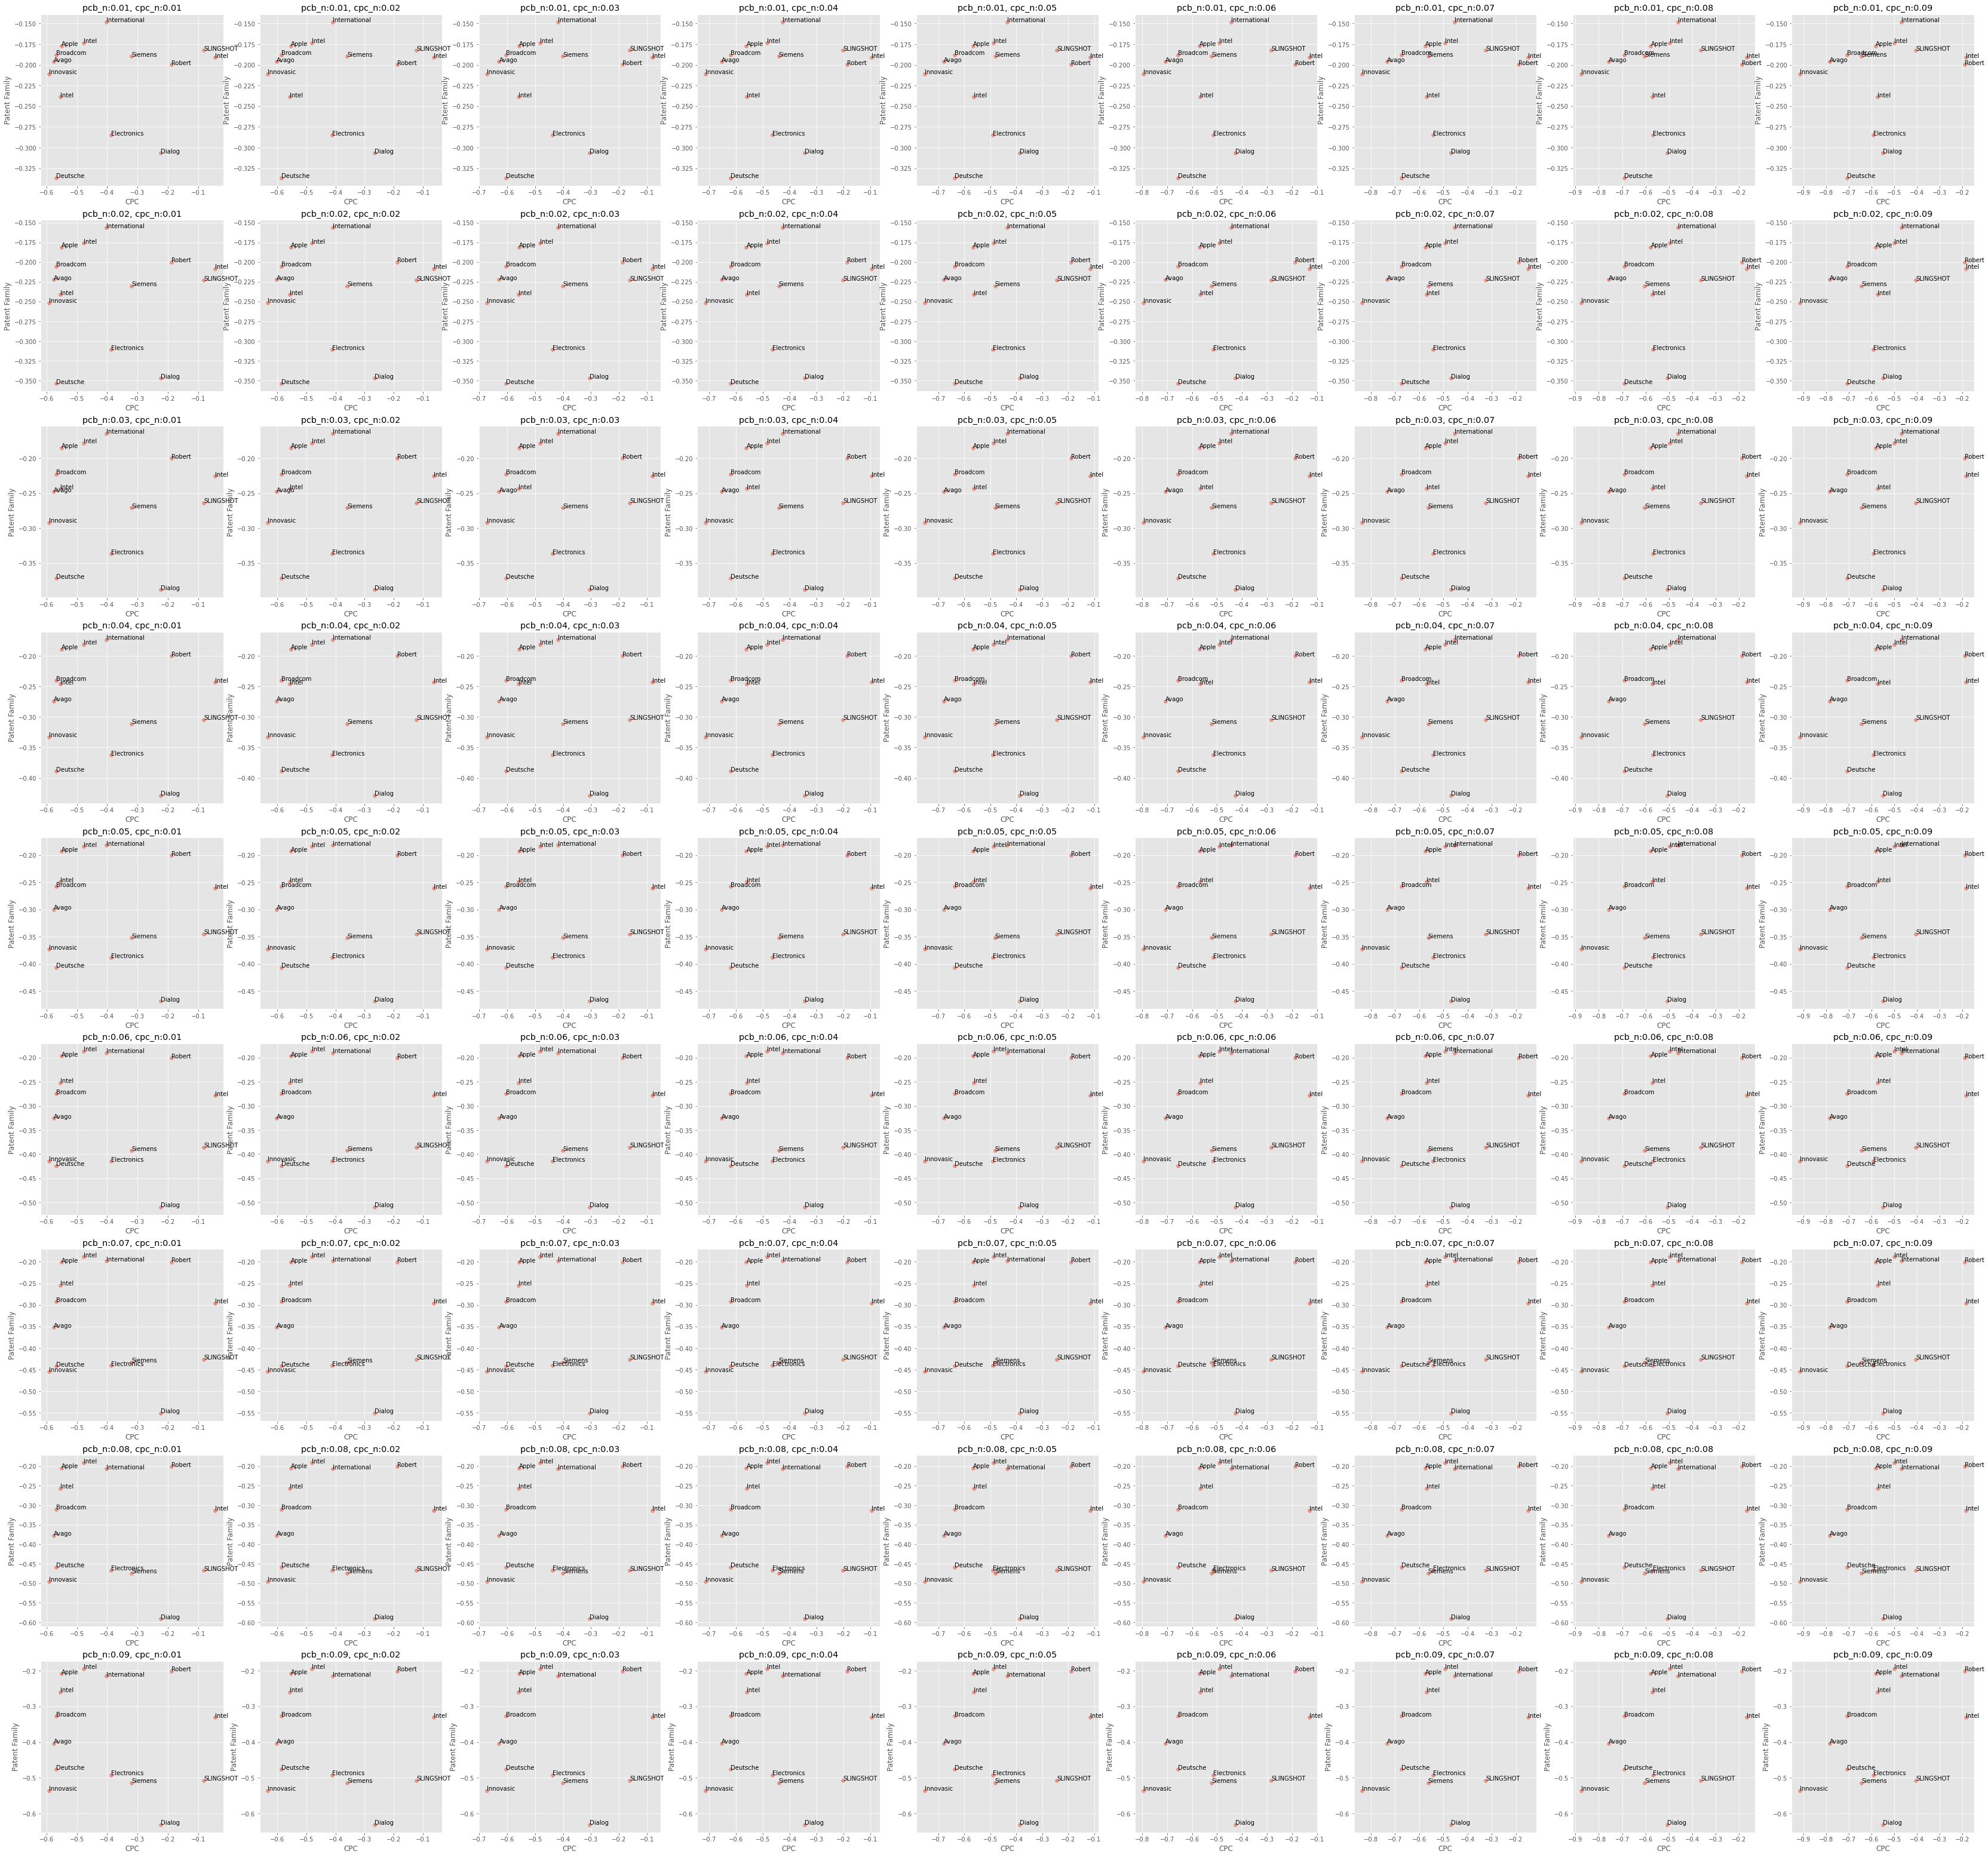

In [42]:
pcb_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pcb_n in enumerate(pcb_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pcb_n,cpc_n)
        c_df = scatter_plot(pcb_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pcb_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pcb_n:{}, cpc_n:{}".format(round(pcb_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/years/plot_de_5_2.png'.format(pcb_n))

In [43]:
c_df

,cpc,country
company,,
Robert Bosch GmbH,0.189296,0.200937
Intel IP Corp,0.498846,0.194092
Intel Deutschland GmbH,0.574505,0.259462
Apple Inc,0.581734,0.208678
International Business Machines Corp,0.468813,0.215158
Intel Corp,0.184444,0.330638
Broadcom Corp,0.708254,0.327446
Deutsche Telekom AG,0.708254,0.476382
Electronics and Telecommunications Research Institute ETRI,0.593670,0.491991


In [25]:
c_df = pd.DataFrame((zip(list(ccpc_pcb["pcb"]), list(ccontry_pcb["pcb"]))), columns = ['cpc', 'country'])

In [26]:
c_df.set_index(ccpc_pcb.index, inplace=True)
c_df

,cpc,country
company,,
Intel Corp,0.693827,0.428925
Samsung Electronics Co Ltd,0.272210,0.192856
Intel IP Corp,0.310741,0.208408
Apple Inc,0.401043,0.257728
Robert Bosch GmbH,0.465879,0.348799
LG Electronics Inc,0.868951,0.535510
Siemens AG,1.098786,0.640949
Fraunhofer Gesellschaft zur Forderung der Angewandten Forschung eV,1.150123,0.671410
Sony Corp,1.347253,0.795505


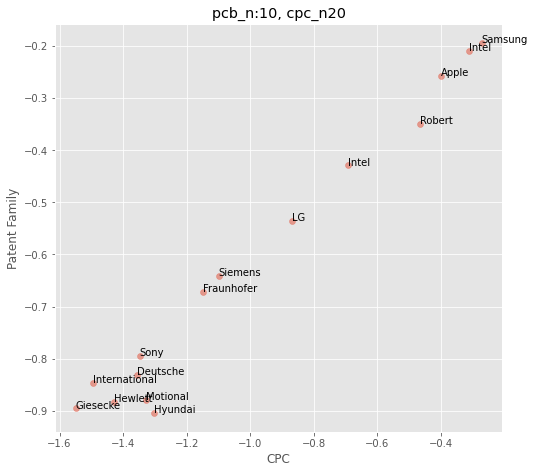

In [30]:
plt.figure(figsize=(8,7.5))
plt.style.use('ggplot')

pcb_n=10
cpc_n=20
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pcb_n:{}, cpc_n{}".format(pcb_n,cpc_n))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])
    

plt.savefig('./img/de/plot_de_pcbn_{}_cpcn_{}.png'.format(pcb_n,cpc_n))
plt.show()

# Scatter Plot 2
- Robert Bosch GmbH

In [143]:
ccontry_pcb_ibm = ccontry2.loc[com_ls,:].copy()
ccontry_pcb_ibm["sum"] = ccontry_pcb_ibm.apply(lambda x: PCB(ccontry_pcb_ibm.loc["Robert Bosch GmbH",:],x), axis=1)

In [150]:
pcb_ls=[]
n=0.08

for i in ccontry_pcb_ibm.index:
    pcb = ccontry_pcb_ibm.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Robert Bosch GmbH"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccontry_pcb_ibm["pcb"]=pcb_ls

In [151]:
ccpc_pcb_ibm = ccpc2.loc[com_ls,:].copy()
ccpc_pcb_ibm["sum"] = ccpc_pcb_ibm.apply(lambda x: PCB(ccpc_pcb_ibm.loc["Robert Bosch GmbH",:],x), axis=1)

In [152]:
pcb_ls=[]
n=0.1

for i in ccpc_pcb_ibm.index:
    pcb = ccpc_pcb_ibm.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Robert Bosch GmbH"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccpc_pcb_ibm["pcb"]=pcb_ls

In [153]:
c_df = pd.DataFrame((zip(list(ccpc_pcb_ibm["pcb"]), list(ccontry_pcb_ibm["pcb"]))), columns = ['cpc', 'country'])
c_df.set_index(ccpc_pcb_ibm.index, inplace=True)

In [154]:
# c_df

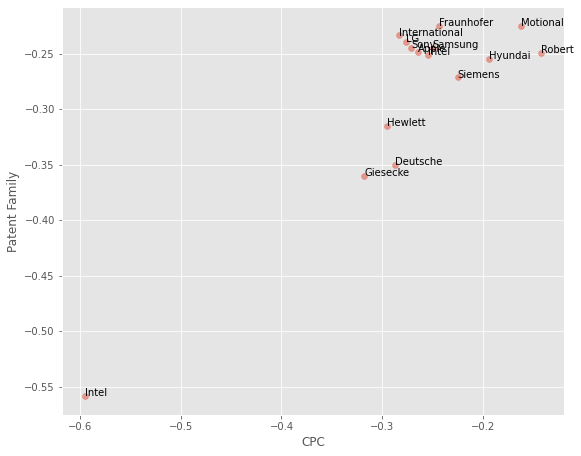

In [155]:
plt.figure(figsize=(9,7.5))
plt.style.use('ggplot')

plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])
    
plt.show()

# Scatter Plot 3
- 全部

In [67]:
com_df2=com_df.copy()

In [68]:
com_df2.loc[len(com_df2)]=["all",33072,10.40644228192155]

In [69]:
com_df2

,company,count,count_log
0,Qualcomm Inc,8491,9.046762
1,Samsung Electronics Co Ltd,6337,8.754161
2,Intel Corp,3236,8.082093
3,Telefonaktiebolaget LM Ericsson AB,2488,7.819234
4,Huawei Technologies Co Ltd,2461,7.808323
5,LG Electronics Inc,1931,7.565793
6,International Business Machines Corp,1591,7.372118
7,Apple Inc,1104,7.006695
8,Cisco Technology Inc,1092,6.995766
9,Microsoft Technology Licensing LLC,963,6.870053


In [70]:
ccontry_all = ccontry.loc[com_ls,:].copy()
ccontry_all.loc["all"] = list(ccontry_all.apply(lambda x: sum(x),axis=0))
ccontry_all

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,SI,SM,TN,TR,TW,UA,US,UY,WO,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.0,14.0,0.0,528.0,0.0,0.0,1328.0,532.0,0.0,57.0,...,12.0,0.0,8.0,0.0,2153.0,0.0,8345.0,0.0,7747.0,17.0
Samsung Electronics Co Ltd,0.0,0.0,0.0,147.0,0.0,0.0,9.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,217.0,0.0,6175.0,0.0,3438.0,0.0
Intel Corp,0.0,0.0,0.0,9.0,0.0,0.0,60.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,167.0,0.0,3254.0,0.0,1546.0,0.0
Telefonaktiebolaget LM Ericsson AB,2.0,182.0,0.0,136.0,0.0,0.0,348.0,140.0,0.0,21.0,...,0.0,0.0,0.0,7.0,61.0,0.0,2331.0,0.0,2436.0,139.0
Huawei Technologies Co Ltd,0.0,2.0,0.0,75.0,0.0,0.0,204.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1341.0,0.0,2117.0,4.0
LG Electronics Inc,0.0,1.0,0.0,31.0,0.0,0.0,25.0,16.0,0.0,12.0,...,0.0,0.0,0.0,0.0,10.0,0.0,1859.0,0.0,1294.0,1.0
International Business Machines Corp,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1687.0,0.0,142.0,2.0
Apple Inc,0.0,0.0,0.0,8.0,0.0,0.0,18.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,62.0,0.0,1045.0,0.0,1013.0,0.0
Cisco Technology Inc,0.0,0.0,0.0,13.0,0.0,0.0,0.0,54.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1160.0,0.0,326.0,0.0


In [71]:
ccontry_pcb_all = ccontry_all.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1
ccontry_pcb_all["sum"] = ccontry_pcb_all.apply(lambda x: PCB(ccontry_pcb_all.loc["all",:],x), axis=1)

In [72]:
pcb_ls=[]

for i in ccontry_pcb_all.index:
    pcb = ccontry_pcb_all.loc[[i],:]["sum"].values+(com_df2.count_log[com_df2.company=="all"].values-com_df2.count_log[com_df2.company==i].values)**2
    pcb_ls.append(pcb[0])
    
ccontry_pcb_all["pcb"]=pcb_ls

In [73]:
ccontry_pcb_all

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,TN,TR,TW,UA,US,UY,WO,ZA,sum,pcb
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.000397,0.0,0.014962,0.0,0.0,0.037632,0.015076,0.0,0.001615,...,0.000227,0.000000,0.061011,0.0,0.236476,0.0,0.219530,0.000482,0.158672,2.007403
Samsung Electronics Co Ltd,0.000000,0.000000,0.0,0.006181,0.0,0.0,0.000378,0.001430,0.0,0.000000,...,0.000000,0.000000,0.009124,0.0,0.259628,0.0,0.144551,0.000000,0.166404,2.896438
Intel Corp,0.000000,0.000000,0.0,0.001009,0.0,0.0,0.006723,0.000448,0.0,0.000000,...,0.000000,0.000000,0.018714,0.0,0.364635,0.0,0.173241,0.000000,0.177056,5.579654
Telefonaktiebolaget LM Ericsson AB,0.000166,0.015076,0.0,0.011266,0.0,0.0,0.028827,0.011597,0.0,0.001740,...,0.000000,0.000580,0.005053,0.0,0.193091,0.0,0.201789,0.011514,0.146153,6.839798
Huawei Technologies Co Ltd,0.000000,0.000249,0.0,0.009330,0.0,0.0,0.025376,0.010076,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.166812,0.0,0.263341,0.000498,0.174032,6.924255
LG Electronics Inc,0.000000,0.000169,0.0,0.005237,0.0,0.0,0.004224,0.002703,0.0,0.002027,...,0.000000,0.000000,0.001689,0.0,0.314073,0.0,0.218618,0.000169,0.175053,8.244340
International Business Machines Corp,0.000000,0.000000,0.0,0.000433,0.0,0.0,0.000867,0.000433,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.730936,0.0,0.061525,0.000867,0.221396,9.428520
Apple Inc,0.000000,0.000000,0.0,0.001978,0.0,0.0,0.004450,0.000494,0.0,0.000000,...,0.000000,0.000000,0.015328,0.0,0.258344,0.0,0.250433,0.000000,0.177627,11.735907
Cisco Technology Inc,0.000000,0.000000,0.0,0.006523,0.0,0.0,0.000000,0.027095,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.582037,0.0,0.163573,0.000000,0.217016,11.849727


In [74]:
ccpc

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
company,,,,,,,,,,,,,,,,,,,,,
#glowontech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(c-Dot),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0
01 Bulletin Laboratory Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
01 COMMUNIQUE LABORATORY Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
0Chain LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
incNETWORKS Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0
mSignia Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
nChain Holdings Ltd,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,138.0,0.0,0.0,0.0,0.0


In [75]:
# ccpc.set_index("company", inplace=True)
ccpc_all = ccpc.loc[com_ls,:].copy()
ccpc_all.loc["all"] = list(ccpc_all.apply(lambda x: sum(x),axis=0))

In [76]:
ccpc_all2 = ccpc_all.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

# ccpc_pcb_ibm = ccpc2.loc[com_ls,:].copy()
ccpc_all2["sum"] = ccpc_all2.apply(lambda x: PCB(ccpc_all2.loc["all",:],x), axis=1)

In [77]:
ccpc_all2

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,...,0.0,0.027181,0.000976,0.017746,0.895970,0.001837,0.008356,0.000287,0.000000,0.609196
Samsung Electronics Co Ltd,0.000000,0.0,0.0,0.000027,0.000000,0.000135,0.000014,0.000122,0.000243,0.000635,...,0.0,0.061415,0.013321,0.015469,0.511531,0.012415,0.009308,0.000405,0.000230,0.384074
Intel Corp,0.000427,0.0,0.0,0.000000,0.000000,0.000152,0.000000,0.000091,0.000000,0.000000,...,0.0,0.108724,0.011915,0.013408,0.471676,0.007283,0.014596,0.001006,0.000061,0.368426
Telefonaktiebolaget LM Ericsson AB,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.003385,0.000564,0.011566,0.919544,0.001016,0.012130,0.000621,0.000000,0.624779
Huawei Technologies Co Ltd,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.007350,0.000817,0.013476,0.901762,0.000992,0.014409,0.000233,0.000000,0.615068
LG Electronics Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000132,0.000044,0.000000,0.000175,...,0.0,0.002325,0.001491,0.003334,0.618222,0.003115,0.008291,0.000307,0.000000,0.438017
International Business Machines Corp,0.001758,0.0,0.0,0.000000,0.000070,0.000070,0.000000,0.000000,0.000000,0.000000,...,0.0,0.078492,0.007455,0.002391,0.264594,0.001829,0.009917,0.002040,0.000141,0.252434
Apple Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.002985,0.001357,0.004884,0.930361,0.000000,0.012119,0.000090,0.000000,0.631630
Cisco Technology Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.004466,0.006597,0.001522,0.746575,0.003451,0.013701,0.004770,0.000101,0.532885


In [78]:
pcb_ls=[]

for i in ccpc_all2.index:
    pcb = ccpc_all2.loc[[i],:]["sum"].values+(com_df2.count_log[com_df2.company=="all"].values-com_df2.count_log[com_df2.company==i].values)**2
    pcb_ls.append(pcb[0])
#     print(ccpc_all.loc[[i],:]["sum"].values)
    
ccpc_all2["pcb"]=pcb_ls

In [79]:
c_df = pd.DataFrame((zip(list(ccpc_all2["pcb"]), list(ccontry_pcb_all["pcb"]))), columns = ['cpc', 'country'])
c_df.set_index(ccpc_all2.index, inplace=True)

In [80]:
c_df

,cpc,country
company,,
Qualcomm Inc,2.457926,2.007403
Samsung Electronics Co Ltd,3.114108,2.896438
Intel Corp,5.771025,5.579654
Telefonaktiebolaget LM Ericsson AB,7.318423,6.839798
Huawei Technologies Co Ltd,7.365291,6.924255
LG Electronics Inc,8.507303,8.244340
International Business Machines Corp,9.459558,9.428520
Apple Inc,12.189910,11.735907
Cisco Technology Inc,12.165597,11.849727


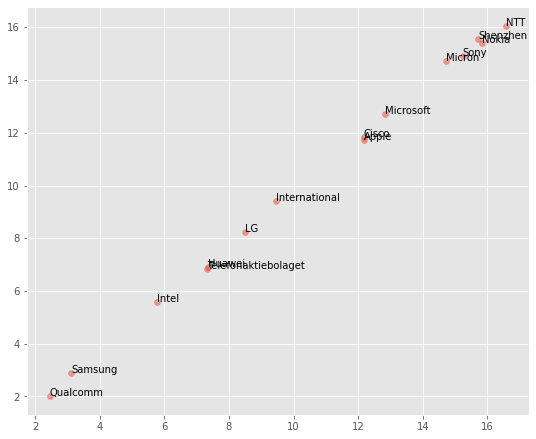

In [81]:
c_df2 = c_df.drop(["all"])

plt.figure(figsize=(9,7.5))
plt.style.use('ggplot')

plt.scatter(c_df2.cpc, c_df2.country, alpha=0.5)

for i, txt in enumerate(c_df2.index):
    plt.text(c_df2.cpc[i], c_df2.country[i],txt.split(" ")[0])
    
plt.show()